# When will monthly arXiv submissions hit 10,000?

In [1]:
from collections import Counter
import itertools as it
from IPython.display import display

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

Use pandas to load the data from the CSV file.

In [4]:
data = pandas.read_csv('get_monthly_submissions')

In [5]:
data

,month,submissions,historical_delta
0,1991-07,0,-2
1,1991-08,27,-1
2,1991-09,58,0
3,1991-10,76,0
4,1991-11,64,0
5,1991-12,78,0
6,1992-01,88,-105
7,1992-02,124,-10
8,1992-03,117,-3
9,1992-04,184,-41


In [6]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
measured_month_names = list(it.chain(*[["{} '{}".format(month, year % 100)
                                        for month in month_names]
                                       for year in range(1991, 2016 + 1)]))[6:-4]

We'll use all but the latest month's data, since submissions are still being added to
September's total.

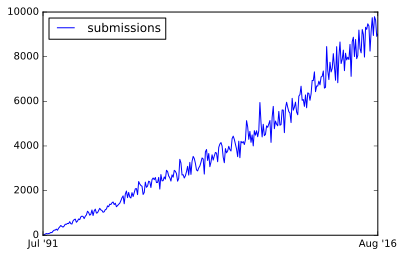

In [7]:
ax = data[:-1].plot(y='submissions')
tick_locations = [0, len(data) - 2]
ax.set_xticks(tick_locations)
ax.set_xticklabels(np.array(measured_month_names)[tick_locations])

There's lots of noise, but one might expect part of that comes from yearly cycles (some months
might be more popular months to submit papers in due to the academic calendar), so let's start
by modeling how the yearly total grows to simplify our picture.

## Yearly growth modeling

In [8]:
yearly_totals = np.array([sum(data['submissions'][12*n:12*n+12])
                          for n in range(len(data) // 12)])
start_years = np.array([1991 + n for n in range(len(yearly_totals))])

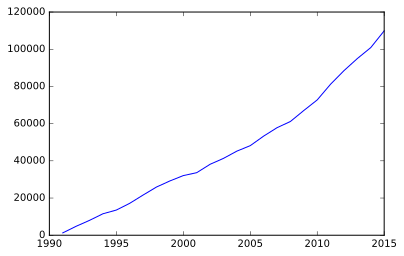

In [9]:
plt.plot(start_years, yearly_totals)

It looks like we might be seeing some exponential growth in more recent years, but the growth
looks pretty linear at the start. Let's look at it on a semilog plot.

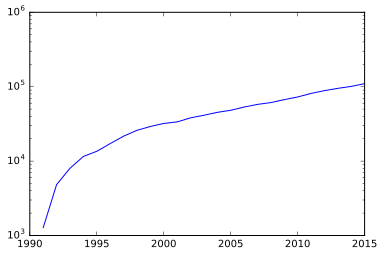

In [10]:
plt.semilogy(start_years, yearly_totals)

Sure enough, the semilog plot looks pretty linear in recent years, so we might try and find an
exponential fit to the yearly data. We'll fit the data with a variety of start points and see
what the earliest start point that gives us a reasonable goodness-of-fit result is as a crude
way of determining what year the exponential trend began.

We need at least three data points to get meaningful fits, so our most recent start time for
the regressions will be back two years from our most recent year.

In [11]:
regressions = [stats.linregress(start_years[n:], np.log(yearly_totals[n:]))
               for n in range(len(yearly_totals) - 2)]

In [12]:
regressions[0]

LinregressResult(slope=0.13127509891504549, intercept=-252.55958069326965, rvalue=0.91389611628770318, pvalue=1.7656919346863394e-10, stderr=0.012158840331414851)

In [13]:
slopes, intercepts, rvalues, pvalues, stderrs = [*zip(*regressions)]

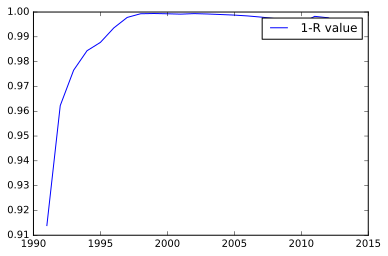

In [14]:
plt.plot(start_years[:-2], rvalues, label='1-R value')
plt.legend()

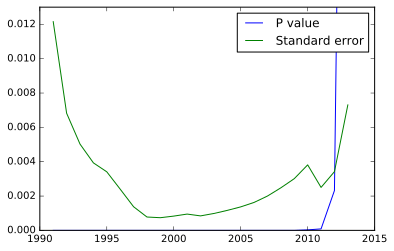

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(start_years[:-2], pvalues, label='P value')
ax.plot(start_years[:-2], stderrs, label='Standard error')
ax.set_ylim(0, 0.013)
ax.legend()

In [16]:
(start_years[np.argmax(rvalues)], start_years[np.argmin(stderrs)],
 start_years[np.argmin(pvalues)])

(1999, 1999, 1998)

These metrics tell us we should probably think of the exponential growth starting around 1999.

Let's plot our fit against the data.

First in semilog

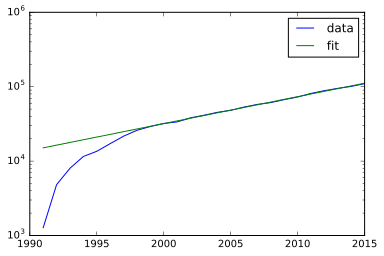

In [17]:
plt.semilogy(start_years, yearly_totals, label='data')
plt.semilogy(start_years, np.exp(slopes[np.argmax(rvalues)]*start_years
                                 + intercepts[np.argmax(rvalues)]), label='fit')
plt.legend()

Then normally.

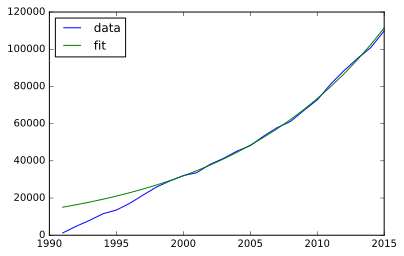

In [18]:
plt.plot(start_years, yearly_totals, label='data')
plt.plot(start_years, np.exp(slopes[np.argmax(rvalues)]*start_years
                             + intercepts[np.argmax(rvalues)]), label='fit')
plt.legend(loc=2)

The fits certainly look decent to the eye!

## Montly fluctuations

Now we would like to know how the month-to-month fluctuations within a year function. One
way to model these fluctuations is to assume that the relative productivities of different
months within a year is roughly constant across all years. Let's calculate the fraction of
yearly output for each month (going up through June 2016, since we don't have a yearly total for July 2016 through June 2017).

In [19]:
monthly_fracs = data['submissions'][:12*len(yearly_totals)].reshape((-1, 12)).T / yearly_totals

In [20]:
monthly_fracs.shape

(12, 25)

(-0.5, 11.5)

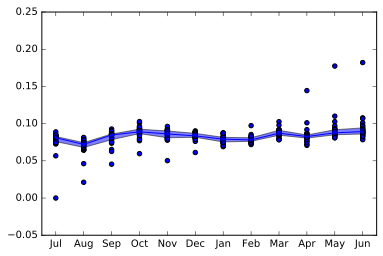

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(np.repeat(list(range(12)), 25), monthly_fracs.reshape(-1))
ax.fill_between(list(range(12)), np.percentile(monthly_fracs, 25, axis=1),
                np.percentile(monthly_fracs, 75, axis=1), alpha=0.5)
ax.plot(list(range(12)), np.median(monthly_fracs, axis=1))
ax.set_xticks(list(range(12)))
ax.set_xticklabels(month_names[6:] + month_names[:6])
ax.set_xlim(-0.5, 11.5)

It looks like we have some significant oscillations from month-to-month as measured by the
width of the inner quartiles (shaded region), as well as some outliers. The median is plotted
as the solid blue line.

Let's see how well combining the median and inner quartile region for the monthly fractions
with our yearly exponential fit matches the data.

In [22]:
modeled_start_years = np.array([1991 + n for n in range(len(yearly_totals) + 1)])
modeled_yearly_totals = np.exp(slopes[np.argmax(rvalues)]*modeled_start_years
                               + intercepts[np.argmax(rvalues)])

In [23]:
monthly_fracs_quartiles = np.percentile(monthly_fracs, [25, 50, 75], axis=1)

In [24]:
monthly_fracs_quartiles.shape

(3, 12)

In [25]:
modeled_yearly_totals.shape

(26,)

In [26]:
modeled_quartiles = (monthly_fracs_quartiles[:,np.newaxis,:]
                     * modeled_yearly_totals[np.newaxis,:,np.newaxis]).reshape((3,-1))

In [27]:
modeled_quartiles.shape

(3, 312)

In [28]:
modeled_month_names = list(it.chain(*[["{} '{}".format(month, year % 100)
                                  for month in month_names]
                                 for year in range(1991, 2017 + 1)]))[6:-6]

(0, 311)

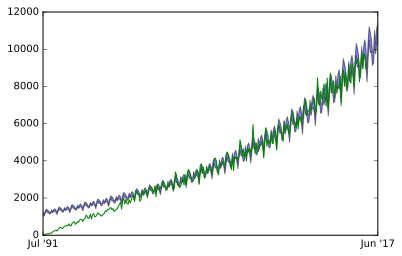

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.fill_between(range(modeled_quartiles.shape[1]), modeled_quartiles[0],
                modeled_quartiles[2], alpha=0.5)
ax.plot(data['submissions'][:-1], color='g')
tick_locations = [0, modeled_quartiles.shape[1] - 1]
ax.set_xticks(tick_locations)
ax.set_xticklabels(np.array(modeled_month_names)[tick_locations])
ax.set_xlim(tick_locations)

(3.7, 4.1)

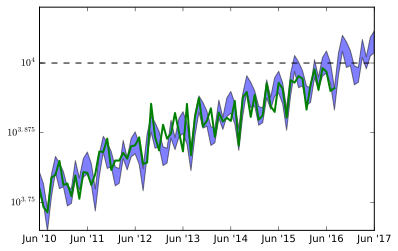

In [30]:
tick_locations = range(227, modeled_quartiles.shape[1], 12)
xmin = tick_locations[0]
xmax = tick_locations[-1]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.fill_between(range(modeled_quartiles.shape[1]), np.log10(modeled_quartiles[0]),
                np.log10(modeled_quartiles[2]), alpha=0.5)
ax.plot(np.log10(data['submissions'][:-1]), color='g', linewidth=2)
ax.hlines(4, xmin, xmax, linestyle='--')
ax.set_xticks(tick_locations)
ax.set_xticklabels(np.array(modeled_month_names)[tick_locations])
ax.set_yticks([3.75, 3.875, 4])
ax.set_yticklabels(['$10^{3.75}$', '$10^{3.875}$', '$10^4$'])
ax.set_xlim(xmin, xmax)
ax.set_ylim([3.7, 4.1])

This looks decent, although there is clearly a lot of noise that we haven't accounted for.
We do seem to roughly track the fluctuations with our simple model, though, so we'll run with
it.

## The prediction

Now let's assume that in the coming months the number of monthly submissions will be the
predicted yearly total times a fraction sampled uniformly from the fractions of yearly
submissions the month in question has had historically. This allows us to calculate a
probability for each upcoming month to have a number of submissions in excess of 10,000. The
probability that a given month will be the first to have 10,000 submissions will then be
the probability that none of the preceeding months had 10,000 submissions times the
probability that the given month will. Using this, we can come up with probabilities for
upcoming months to be the first month to have 10,000 submissions.

In [31]:
class html_table(list):
    def __init__(self, list_data, first_row=None, first_col=None):
        super().__init__(list_data)
        self.first_row = first_row
        self.first_col = first_col

    def _repr_html_(self):
        html = '<table>'
        if self.first_row is not None:
            html += '<tr>'
            if self.first_col is not None:
                html += '<td></td>'
            for entry in self.first_row:
                html += '<td><strong>{}</strong></td>'.format(entry)
            html += '</tr>'
        for n, row in enumerate(self):
            html += '<tr>'
            if self.first_col is not None:
                html += '<td><strong>{}</strong></td>'.format(self.first_col[n])
            for entry in row:
                html += '<td>{}</td>'.format(entry)
            html += '</tr>'
        html += '</table>'
        return html

In [32]:
modeled_samples = (monthly_fracs * modeled_yearly_totals[-1])

In [33]:
counts = Counter(np.where(modeled_samples >= 10000)[0])

In [34]:
month_probs = [(n, counts[n]/25) for n in counts if n > 1]

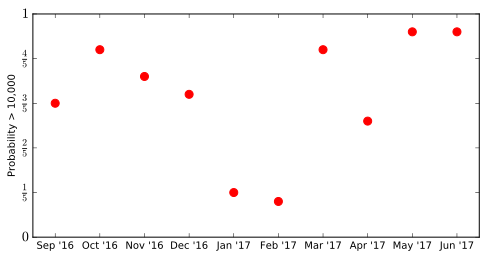

Sep '16,Oct '16,Nov '16,Dec '16,Jan '17,Feb '17,Mar '17,Apr '17,May '17,Jun '17
60%,84%,72%,64%,20%,16%,84%,52%,92%,92%


In [35]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(*zip(*month_probs), color='r', s=64)
ax.set_xticks(range(2, 12))
ax.set_xticklabels(modeled_month_names[-10:])
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels(['$0$'] + [r'$\frac{' + str(n) + '}{5}$' for n in range(1, 5)] + ['$1$'],
                  fontsize=14)
ax.set_xlim(1.5, 11.5)
ax.set_ylabel('Probability > 10,000')
plt.show()
display(html_table([['{:.0f}%'.format(100*prob) for prob in list(zip(*month_probs))[1]]],
                   modeled_month_names[-10:]))

In [36]:
first_probs = []
months = []
prob_attained = 0.
for month, prob in month_probs:
    prob_this_month = (1 - prob_attained) * prob
    first_probs.append(prob_this_month)
    months.append(month)
    prob_attained = prob_attained + prob_this_month
cumulative_probs = list(it.accumulate(first_probs))

Our model predicts that the arXiv will almost certainly have a month with at least 10,000
submissions by the end of the year:

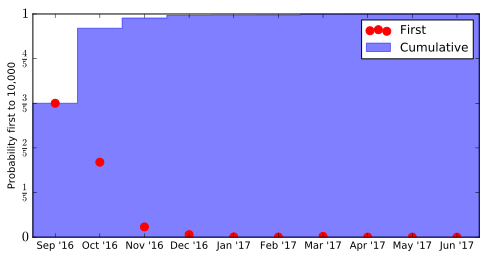

,Sep '16,Oct '16,Nov '16,Dec '16,Jan '17,Feb '17,Mar '17,Apr '17,May '17,Jun '17
First,60.000%,33.600%,4.608%,1.147%,0.129%,0.083%,0.364%,0.036%,0.031%,0.002%
Cumulative,60.000%,93.600%,98.208%,99.355%,99.484%,99.566%,99.931%,99.967%,99.997%,100.000%


In [37]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(months, first_probs, color='r', s=64, label='First', zorder=1)
ax.fill_between(np.repeat(np.linspace(1.5, 11.5, 11), 2)[1:-1],
                np.repeat(cumulative_probs, 2), color='b', alpha=0.5,
                label='Cumulative', zorder=0)
ax.set_xticks(range(2, 12))
ax.set_xticklabels(modeled_month_names[-10:])
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels(['$0$'] + [r'$\frac{' + str(n) + '}{5}$' for n in range(1, 5)] + ['$1$'],
                  fontsize=14)
ax.set_xlim(1.5, 11.5)
ax.set_ylim(0, 1)
ax.set_ylabel('Probability first to 10,000')
ax.legend()
plt.show()
display(html_table([['{:.3f}%'.format(100*prob) for prob in first_probs],
                    ['{:.3f}%'.format(100*prob) for prob in cumulative_probs]],
                   modeled_month_names[-10:],
                   ['First', 'Cumulative']))